# Project Notebook

## 25.12.2019
### Data Processing
*Ro-ee Tal*

- Created a custom data transformer to transform Shapefile annotations of dataset into COCO format for compatible use with Detectron2.

- There is misalignement in the dataset images and corresponding annotations. For now the conversion from GIS latitude and longitude coordinates to pixel coordinates has been hardcoded, but should be dealt with to correct alignment.

- Segment classification has been preserved, but can be modified to restrict segmentation to a single class (i.e. tree) initially as apposed to tree types.

## 02.01.2020
### Data Processing
*Ro-ee Tal*

- The misalignment has now been corrected for, by dynamically using GIS libraries.
- This custom data loader also supports multiple datasets (all within a main dataset directory), but for single orthographic images.
- These single annotated orthographic images still need to be cut up into fixed sized samples.

In [1]:
# define path to visualize COCO transformed dataset
dataset_path = "/Users/Ro/Google Drive/UBC_EngCapstone/sample_data/CPT2a-n"

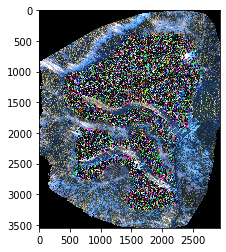

In [4]:
import detectron2
from detectron2.utils.visualizer import Visualizer
import cv2
from data.register_shapefile_datatset import shapefile_to_coco_dict
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt

classes, dataset_dicts = shapefile_to_coco_dict(dataset_path)
img = cv2.imread(dataset_path+'/CPT2a-n_ortho-resample.tif')
visualizer = Visualizer(img[:, :, :], metadata=MetadataCatalog.get("CPT2a-n"), scale=1)
vis = visualizer.draw_dataset_dict(dataset_dicts[0])
plt.imshow(vis.get_image()[:, :, ::-1])
plt.show()

## 03.01.2020
### Training
*Ro-ee Tal*

Run 'dummy' training on some annotated orthos to test the pipline.

In [4]:
# Register all Shapefile datasets into COCO for Detectrons

import os
import detectron2
from data.register_shapefile_datatset import shapefile_to_coco_dict
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_path = "/Users/Ro/Google Drive/UBC_EngCapstone/sample_data/"

datasets = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d)) and os.path.isdir(os.path.join(dataset_path, d + '/Segments'))]
# for dataset in datasets:
dataset = datasets[0]
if dataset not in DatasetCatalog.list():
    classes, dataset_dicts = shapefile_to_coco_dict(os.path.join(dataset_path, dataset))
    DatasetCatalog.register(dataset, lambda : dataset_dicts)
    MetadataCatalog.get(dataset).set(thing_classes=classes)

CPT2a-n


In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
# Device -> CPU for now
cfg.MODEL.DEVICE = 'cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (dataset,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1
# cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # Let training initialize from model zoo
# Downloaded manually due to SSL certification error
cfg.MODEL.WEIGHTS = os.path.realpath('model_zoo/model_final_f10217.pkl')
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (tree)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Config '/Users/Ro/Documents/github/drone-tree-id/lib/detectron2_repo/detectron2/model_zoo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


OrderedDict()

In [26]:
from detectron2.engine import DefaultPredictor
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = (dataset, )
predictor = DefaultPredictor(cfg)

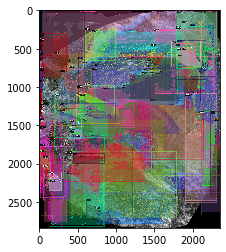

In [27]:
from detectron2.utils.visualizer import ColorMode, Visualizer
import matplotlib.pyplot as plt
from data.register_shapefile_datatset import shapefile_to_coco_dict
import cv2

dataset_path = "/Users/Ro/Google Drive/UBC_EngCapstone/sample_data/CPT2a-n"
_, dataset_dicts = shapefile_to_coco_dict(dataset_path)
im = cv2.imread(dataset_dicts[0]["file_name"])
outputs = predictor(im)
v = Visualizer(im[:, :, :],
               metadata=MetadataCatalog.get("CPT2a-n"), 
               scale=0.8, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])
plt.show()

## 05.01.20
### Data Investigation
*Tom Ginsberg*

The first step in the data investigation porcess was to take a look at the polygons in the training data

In [33]:
import shapefile
import numpy as np
import matplotlib.pyplot as plt

In [36]:
sf = shapefile.Reader("../datasets/CPT2a-n/Segments/CPT2a-n_dom-poly")
print(sf)

shapefile Reader
    9252 shapes (type 'POLYGON')
    9252 records (4 fields)


Let's see what a random sample of 125 polygons look like.

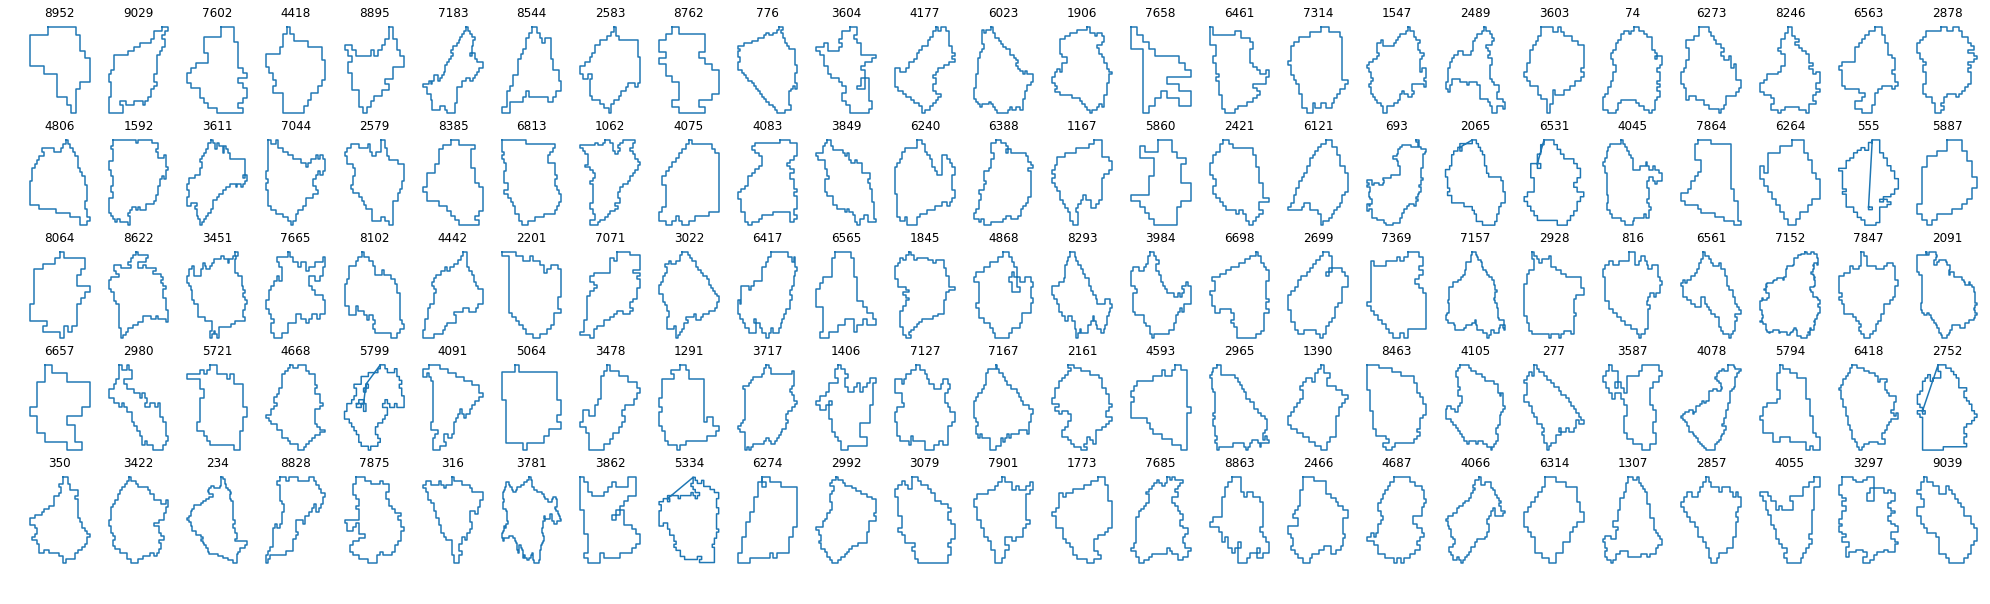

In [40]:
shapes = sf.shapes()
num_shapes = len(shapes)
fig, axes = plt.subplots(5, 25, figsize=(35,10))
for ax in axes.ravel():
    idx = np.random.randint(num_shapes)
    ax.set_title(f'{idx}')
    ax.plot(*np.array((shapes[idx].points)).transpose())
    ax.set_axis_off()

It looks like the polygons are heavily pixelated. Smoothing them would result in much less data being required to specify shapes and hence faster training times. We use QGIS weighted area vector simplification with a .5m tolerance. 

#### Simplifed Result

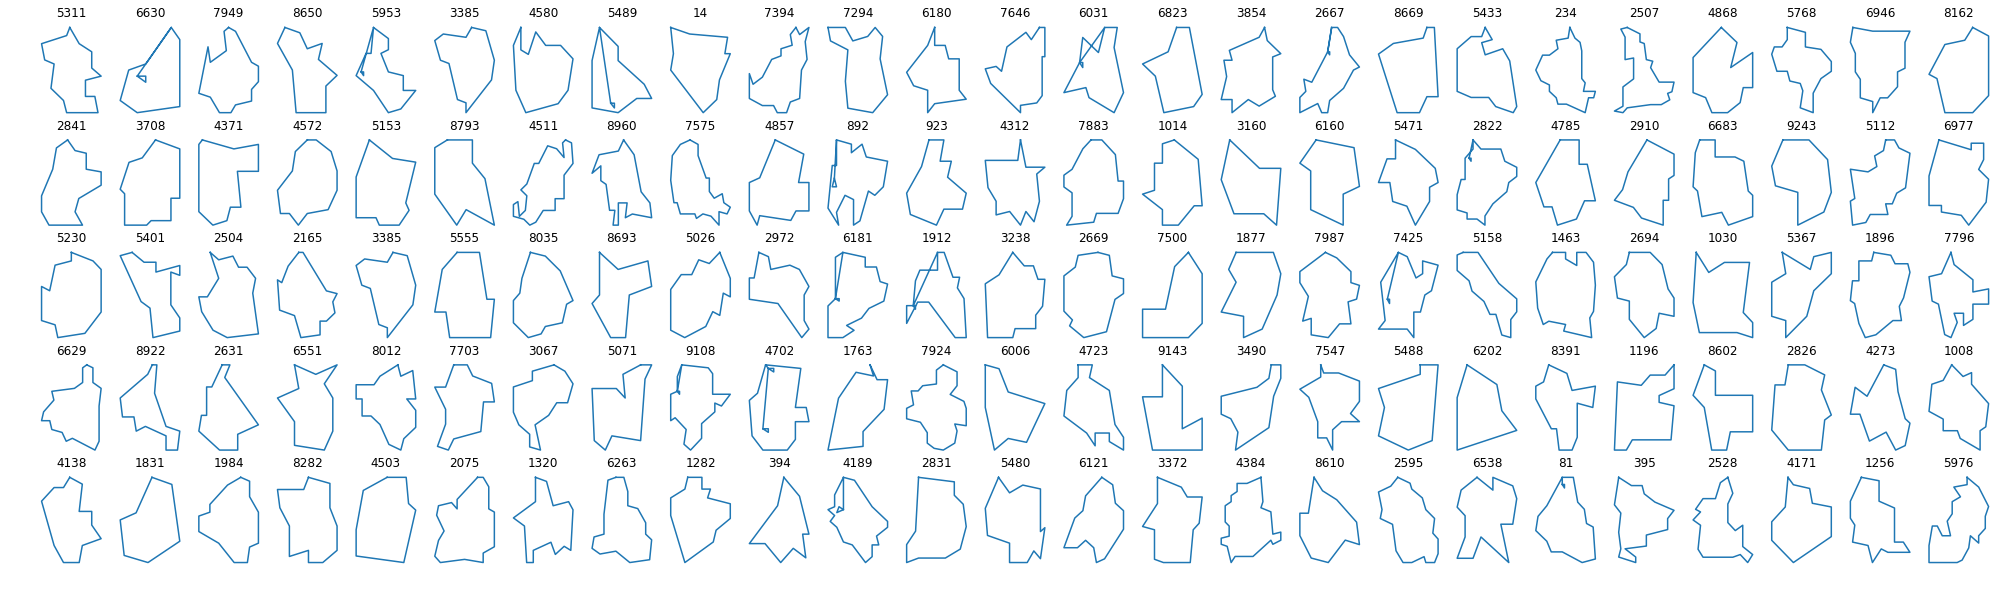

In [42]:
sf = shapefile.Reader("../datasets/CPT2a-n/simple/segs_simple")
shapes = sf.shapes()
num_shapes = len(shapes)
fig, axes = plt.subplots(5, 25, figsize=(35,10))
for ax in axes.ravel():
    idx = np.random.randint(num_shapes)
    ax.set_title(f'{idx}')
    ax.plot(*np.array((shapes[idx].points)).transpose())
    ax.set_axis_off()

Some polygons appear to have strange artifacts. Some examples are shown below.

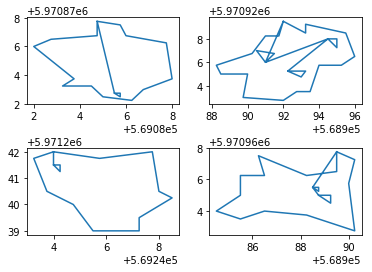

In [44]:
idxs = [6845, 1968, 6420, 5926]

fig, axes = plt.subplots(2, 2)
fig.subplots_adjust(hspace=.5)
for i, idx in enumerate(idxs):
    axes[i%2, (i//2)].plot(*np.array((shapes[idx].points)).transpose())

We try the most naive solution just removing the last few points after the polygon completes itself.

In [46]:
def fix_polygon_tail(polygon):
    # First point in polygon
    first = polygon[0]
    new_poly = []
    for i, p in enumerate(polygon):
        # keep every point up to the re-occurrence of the first point 
        new_poly.append(p)
        if i > 0 and p == first:
            break
    return new_poly

View the improved polygons with no artifacts.

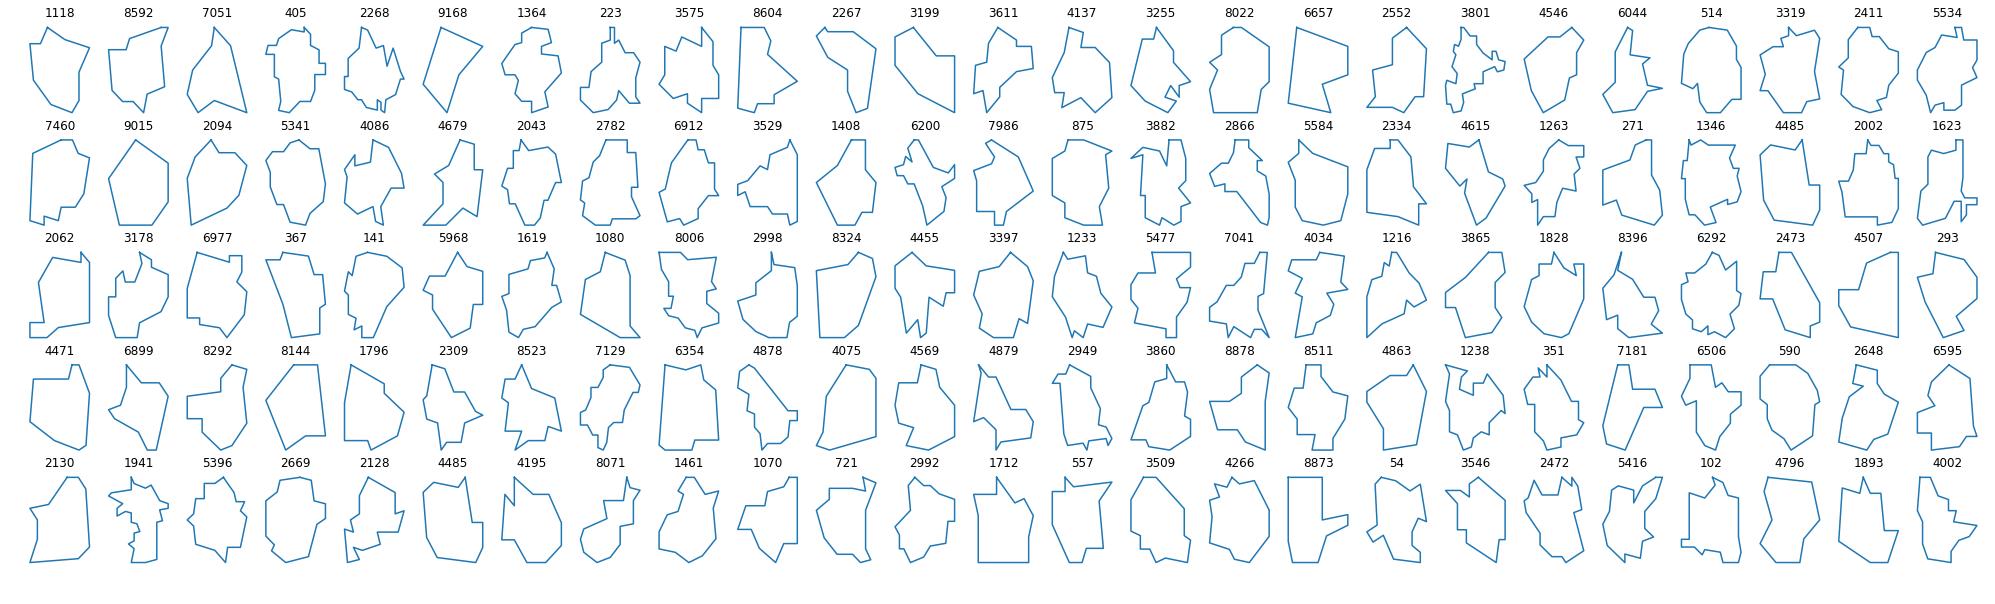

In [47]:
fig, axes = plt.subplots(5, 25, figsize=(35,10))
for ax in axes.ravel():
    idx = np.random.randint(num_shapes)
    ax.set_title(f'{idx}')
    ax.plot(*np.array(fix_polygon_tail(shapes[idx].points)).transpose())
    ax.set_axis_off()

Revisiting the problemactic case from before.

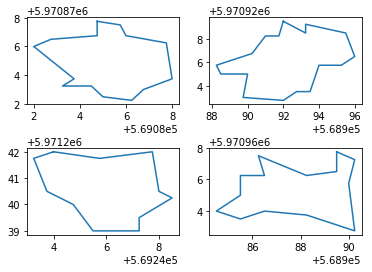

In [49]:
idxs = [6845, 1968, 6420, 5926]

fig, axes = plt.subplots(2, 2)
fig.subplots_adjust(hspace=.5)
for i, idx in enumerate(idxs):
    axes[i%2, (i//2)].plot(*np.array(fix_polygon_tail(shapes[idx].points)).transpose())

## 11.01.20
### Data Prep
*Tom Ginsberg*

Very large images must tiled into smaller images to perform to the specs of common computer vision models. Tiling the image itself is trivial, however a harder task is to tile the training data segments (i.e polygons delineating tree crowns). 

The following code shows the prototyping of an implementation to tile polygons over a grid.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

We start by reading a randomly generated dataset of 100 polygons over a \[100 x 100\] grid.

*Generated with Mathematica using the following* 
```
Table[Translate[RandomPolygon[],RandomReal[99, 2]], 100]
```

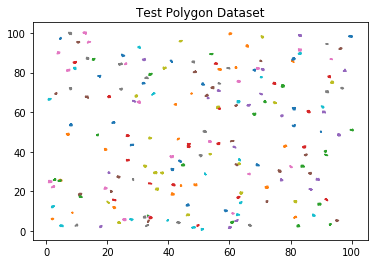

In [11]:
with open('resources/polygons.txt', 'r') as f:
    data = f.read()
    
data = eval(data)
for polygon in data:
    polygon.append(polygon[0])
polygons = [np.array(polygon) for polygon in data][2:]

for polygon in polygons:
    plt.plot(*polygon.transpose());
    
plt.title('Test Polygon Dataset');

Next we compute bounding boxes of polygons

In [12]:
def bbox(poly):
    x, y = poly.transpose()
    return [np.min(x), np.min(y), np.max(x), np.max(y)]

bboxs = [bbox(poly) for poly in polygons]

Now we specify that we want to tile this dataset into \[40 x 40] tiles with an overlay of 10 in both dimensions. 

In [13]:
# Dataset dimensions
x_dim, y_dim = 100, 100

# Grid parameters
w, h, w_overlay, h_overlay = 40, 40, 10, 10

dx, dy = w-w_overlay, h-h_overlay

16 tiles in grid


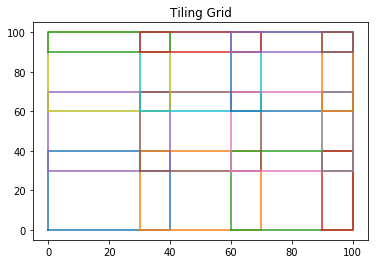

In [16]:
# Visualize the grid 

tile_corners = []
for y in range(0, y_dim, dy):
    for x in range(0, x_dim, dx):    
        x_c = x+w if x+w < x_dim else x_dim 
        y_c = y+h if y+h < y_dim else y_dim
        tile_corners.append([x, y, x_c, y_c])
        plt.plot([x,x,x_c,x_c,x],[y,y_c,y_c,y,y])
        
plt.title('Tiling Grid');

num_tiles = ceil(x_dim /dx) * ceil(y_dim / dy)
print(f'{num_tiles} tiles in grid')

In [19]:
# a few helper functions

def get_bbox_corners(bbox):
    xmi, ymi, xma, yma = bbox
    return np.array([[xmi,ymi],[xmi,yma],[xma,yma],[xma,ymi],[xmi,ymi]])

def if_non_zero(x):
    if x == 0:
        return 0
    return 1

def box_in_box(contained, container):
    """
    :param container: Rectangle [x min, y min, x_max, y_max]
    :param contained: Rectangle [x min, y min, x max, y max]
    :return: T/F Is contained in container?
    """
    if min(container[:2]) < 0:
        return False
    if contained[0] >= container[0] and contained[1] >= container[1] and contained[2] <= container[2] \
            and contained[3] <= container[3]:
        return True
    return False

Select a random polygon and visulaize which grid cells in belongs to out of it's neighboring four.

Polygon Number: 72


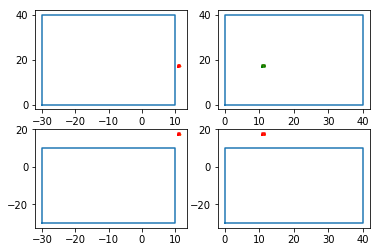

In [29]:
fig, axes = plt.subplots(2,2)
poly_num = np.random.randint(0, len(polygons))
print(f'Polygon Number: {poly_num}')
x_min, y_min, x_max, y_max = bboxs[poly_num]
x_pos, y_pos = x_min // dx, y_min // dy
for x_shift in [0, dx]:
    for y_shift in [0, dy]:
        x, y = dx * x_pos - x_shift, dy * y_pos - y_shift
        x_c = x+w if x+w < x_dim else x_dim 
        y_c = y+h if y+h < y_dim else y_dim 
        
        axes[if_non_zero(y_shift),if_non_zero(x_shift-dx)].plot([x,x,x_c,x_c,x],[y,y_c,y_c,y,y])
        axes[if_non_zero(y_shift),if_non_zero(x_shift-dx)].plot(*polygons[poly_num].transpose())
        
        color = 'g' if box_in_box(bboxs[poly_num], [x, y, x_c, y_c]) else 'r'
        axes[if_non_zero(y_shift),if_non_zero(x_shift-dx)].plot(*get_bbox_corners(bboxs[poly_num]).transpose(), c=color);

Iterate over all the polygons and assign them to the bins that correspond the the grid tiles that they can be found in.

In [30]:
tiles = [[] for _ in range(num_tiles)]
x_tiles = ceil(x_dim / dx)
for poly, bbox in zip(polygons, bboxs):
    x_min, y_min, x_max, y_max = bbox
    x_pos, y_pos = x_min // dx, y_min // dy
    for x_shift in [0, dx]:
        for y_shift in [0, dy]:
            x, y = dx * x_pos - x_shift, dy * y_pos - y_shift
            x_c = x+w if x+w < x_dim else x_dim 
            y_c = y+h if y+h < y_dim else y_dim
            
            x_pos_c, y_pos_c = \
            x_pos - if_non_zero(x_shift), y_pos - if_non_zero(y_shift)
            
            if box_in_box(bbox, [x, y, x_c, y_c]):
                tiles[int((x_tiles) * y_pos_c + x_pos_c)].append(poly)

Visualize the results of the tiling.

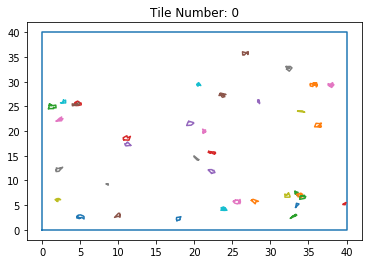

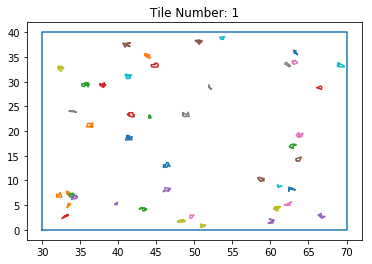

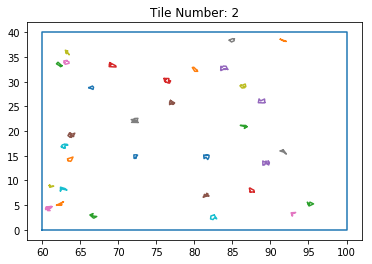

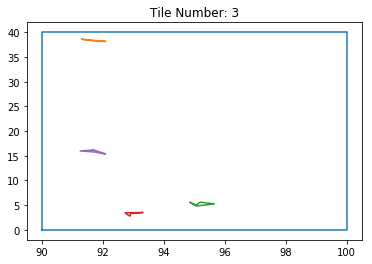

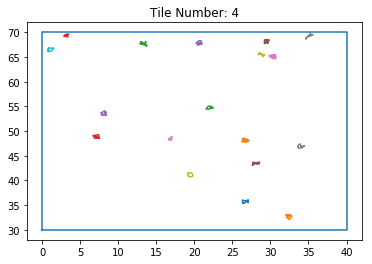

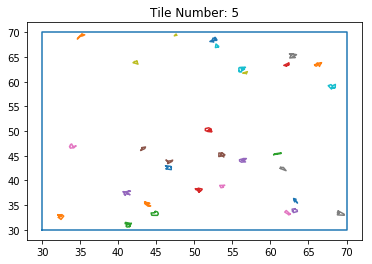

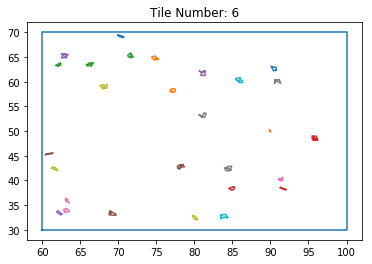

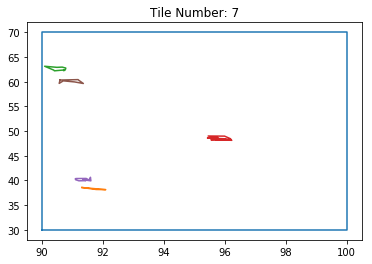

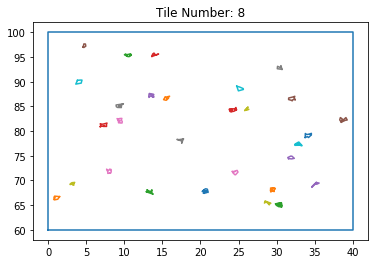

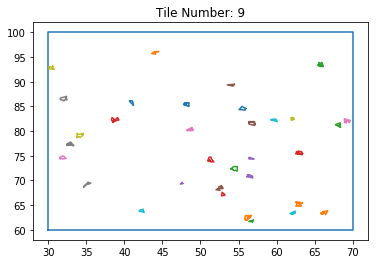

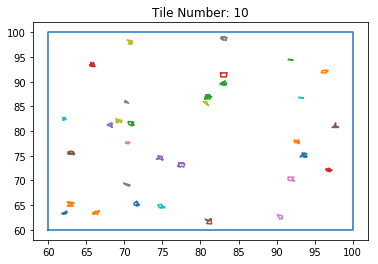

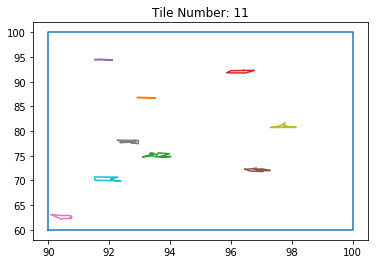

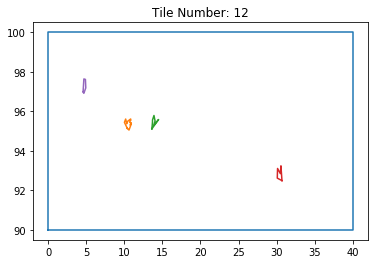

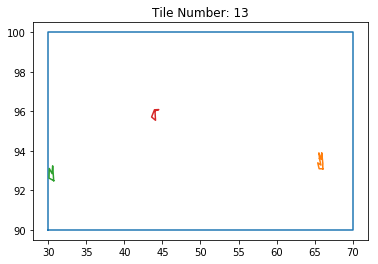

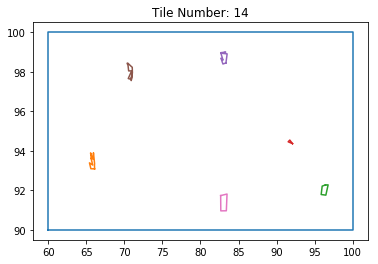

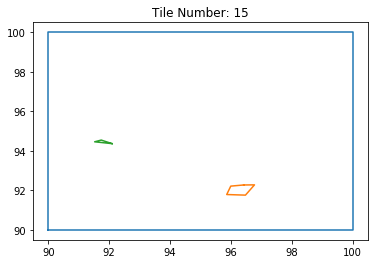

In [31]:
for tile_num, (tile, bound) in enumerate(zip(tiles, tile_corners)):
    plt.plot(*get_bbox_corners(bound).transpose())
    plt.title(f'Tile Number: {tile_num}')
    for poly in tile:
        plt.plot(*poly.transpose());
    plt.show()